In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cd /content/gdrive/MyDrive/trading_bot/

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
file = ''  # elegir una accion de las archivos en Datos/crudos
df = pd.read_csv(file,header=1)
df = df.drop('Unnamed: 0', 1)


In [ ]:
# flas con data
df = df.iloc[:1211,:].copy()

In [ ]:
#df.shape
#df.info()
#df.columns

In [ ]:
# columnas primitivas
df.loc[:, ['Date', 'Open', 'High','Low','Close','Volume']]

df['Open'] = df['Open'].str.replace(',', '.', regex=False).astype(float)
df['High'] = df['High'].str.replace(',', '.', regex=False).astype(float)
df['Low'] = df['Low'].str.replace(',', '.', regex=False).astype(float)
df['Close'] = df['Close'].str.replace(',', '.', regex=False).astype(float)
df['Volume'] = df['Volume'].str.replace(',', '.', regex=False).astype(int)

In [ ]:
df = df.loc[:, ['Date', 'Open', 'High','Low','Close','Volume']]

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")


In [ ]:
# nan
#df.isna().sum()

In [ ]:
#df.dropna(axis=0, how='any', inplace=False)
#df.head()

In [ ]:
df['Open_1'] = df.apply(lambda x: x['Open'] * 1.01, axis=1)
df['mov_high'] = df.apply(lambda x: (x['High'] - x['Open_1']) / x['Open_1'] * 100, axis=1)
df['mov_low'] = df.apply(lambda x: (x['Low'] - x['Open_1']) / x['Open_1'] * 100, axis=1)
df['cierre'] = df.apply(lambda x: (x['Close'] - x['Open_1']) / x['Open_1'] * 100, axis=1)

df['helper_column'] = df['Close'].shift(-1)
df['gap'] = df.apply(lambda x: (x['Open'] - x['helper_column']) / x['helper_column'] * 100, axis=1)
df = df.drop('helper_column', 1)

In [ ]:
df = df.loc[:, ['Date','gap','Open', 'Open_1', 'mov_high', 'mov_low', 'cierre', 'Volume','Close']]

In [ ]:
summary = {'accion':'AA', 'estrategias': {'estrategia_0': {'indicadores':[], 'sample':0, 'per_sample':0}, 'estrategia_1': {'indicadores':[], 'sample':0, 'per_sample':0}, 'estrategia_2': {'indicadores':[],'sample':0, 'per_sample':0}}}

In [ ]:
summary

{'accion': 'AA',
 'estrategias': {'estrategia_0': {'indicadores': [],
   'per_sample': 0,
   'sample': 0},
  'estrategia_1': {'indicadores': [], 'per_sample': 0, 'sample': 0},
  'estrategia_2': {'indicadores': [], 'per_sample': 0, 'sample': 0}}}

#Estrategia 0:  Original

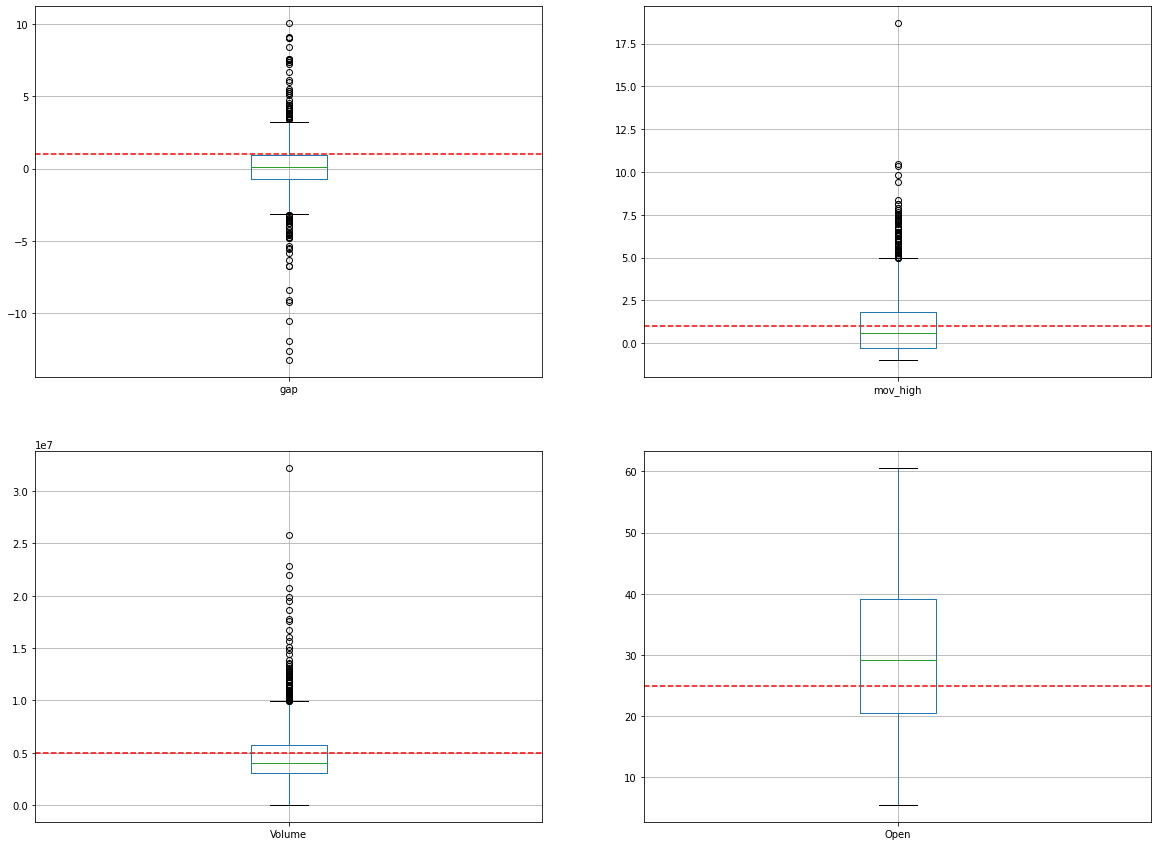

In [ ]:
fig = plt.figure(figsize=(20,15))


ax1 = fig.add_subplot(221)
ax1.axhline(1, c='r', ls='--')

ax2 = fig.add_subplot(222)
ax2.axhline(1, c='r', ls='--')
ax3 = fig.add_subplot(223)
ax3.axhline(5000000, c='r', ls='--')
ax4 = fig.add_subplot(224)
ax4.axhline(25, c='r', ls='--')

df.boxplot('gap',ax=ax1)
df.boxplot('mov_high', ax=ax2)
df.boxplot('Volume', ax=ax3)
df.boxplot('Open', ax=ax4)


In [ ]:
n = len(df)

In [ ]:
df_original = df.copy()

# mov_high > 1% 
df_original = df_original.loc[df_original['mov_high'] >= 1, :]


# gap < 1%
df_original = df_original.loc[df['gap'] <= 1, :]



# Precio > 25 
df_original = df_original.loc[df_original['Open'] >= 25, :]


# Volumen > 500000
df_original = df_original.loc[df_original['Volume'] >= 5000000, :]


n_original = len(df_original)
p_sample = np.round((n_original / n) * 100,2)

summary['estrategias']['estrategia_0']['per_sample'] = p_sample
summary['estrategias']['estrategia_0']['sample'] = n_original

print("Cantidad de puntos utilizados", n_original)
print("Porcentaje de datos utilizados", p_sample)

Cantidad de puntos utilizados 68
Porcentaje de datos utilizados 5.62


In [ ]:
# indicadores

TP_original = np.round(df_original['mov_high'].mean(),2)
SL_original = np.round(df_original['mov_low'].mean(),2) 
TR_original = np.round(df_original['mov_high'].std(),2)

summary['estrategias']['estrategia_0']['indicadores'] = [TR_original, TP_original, SL_original]

print(TP_original, SL_original, TR_original)

3.38 -2.27 1.99


In [ ]:
summary

{'accion': 'AA',
 'estrategias': {'estrategia_0': {'indicadores': [1.99, 3.38, -2.27],
   'per_sample': 5.62,
   'sample': 68},
  'estrategia_1': {'indicadores': [], 'per_sample': 0, 'sample': 0},
  'estrategia_2': {'indicadores': [], 'per_sample': 0, 'sample': 0}}}

## Estrategia 1:  Filtros modificados

### Se aumenta la muestra y se eliminan datos extremos. Se utilizan todos los datos.

* El % del gap no se modifica

* Precio y Volumen > Q2

* Q2 < % mov_high < bigote

In [ ]:
def Q1(col):
  q1 = col.quantile(q=0.25)
  return q1

def Q2(col):
  q2 = col.quantile(q=0.5)
  return q2

def Q3(col):
  q3 = col.quantile(q=0.75)
  return q3

def L_sup(q1, q3):
  whis = 1.5
  l_sup = q3 + whis*(q3-q1)
  return l_sup


In [ ]:
n = len(df)

In [ ]:
df_filtrada = df.copy()


#df_filtrada = df_filtrada.loc[(df_filtrada['mov_high'] < 5) & (df_filtrada['mov_high'] >= 0.62), :]
df_filtrada = df_filtrada.loc[(df_filtrada['mov_high'] < L_sup(Q1(df_filtrada['mov_high']), Q3(df_filtrada['mov_high']))) & (df_filtrada['mov_high'] >= Q2(df_filtrada['mov_high'])), :]
#print(len(df_filtrada) / n * 100)

# gap < 1%
df_filtrada = df_filtrada.loc[df['gap'] <= 3, :]
#print(len(df_filtrada) / n * 100)


# Close > Q2
df_filtrada = df_filtrada.loc[df_filtrada['Close'] >= Q1(df_filtrada['Close']), :]
#print(len(df_filtrada) / n * 100)

# Volumen => Q2
df_filtrada = df_filtrada.loc[df_filtrada['Volume'] >= Q1(df_filtrada['Volume']), :]

n_filtrado = len(df_filtrada)
p_sample = np.round((n_filtrado / n) * 100, 2)

summary['estrategias']['estrategia_1']['per_sample'] = p_sample
summary['estrategias']['estrategia_1']['sample'] = n_filtrado

print("Cantidad de puntos utilizados", n_filtrado)
print("Porcentaje de datos utilizados", p_sample)



Cantidad de puntos utilizados 289
Porcentaje de datos utilizados 23.86


In [ ]:
# indicadores

TP_filtros = np.round(df_filtrada['mov_high'].mean(),2)
SL_filtros = np.round(df_filtrada['mov_low'].mean(),2)
TR_filtros = np.round(df_filtrada['mov_high'].std(),2)

summary['estrategias']['estrategia_1']['indicadores'] = [TR_filtros, TP_filtros, SL_filtros]
print(TR_filtros, TP_filtros, SL_filtros)

1.02 1.99 -2.11


In [ ]:
summary

{'accion': 'AA',
 'estrategias': {'estrategia_0': {'indicadores': [1.99, 3.38, -2.27],
   'per_sample': 5.62,
   'sample': 68},
  'estrategia_1': {'indicadores': [1.02, 1.99, -2.11],
   'per_sample': 23.86,
   'sample': 289},
  'estrategia_2': {'indicadores': [], 'per_sample': 0, 'sample': 0}}}

# Estrategia 2 : 6 meses anteriores

### Los datos se encuentran filtrados como en la Estrategia 1 pero acotados a los ultimos 6 meses

In [ ]:
g = df.groupby(pd.Grouper(key='Date', freq='6M'))
dfs = [ group for _,group in g]
df_6meses = dfs[-1]


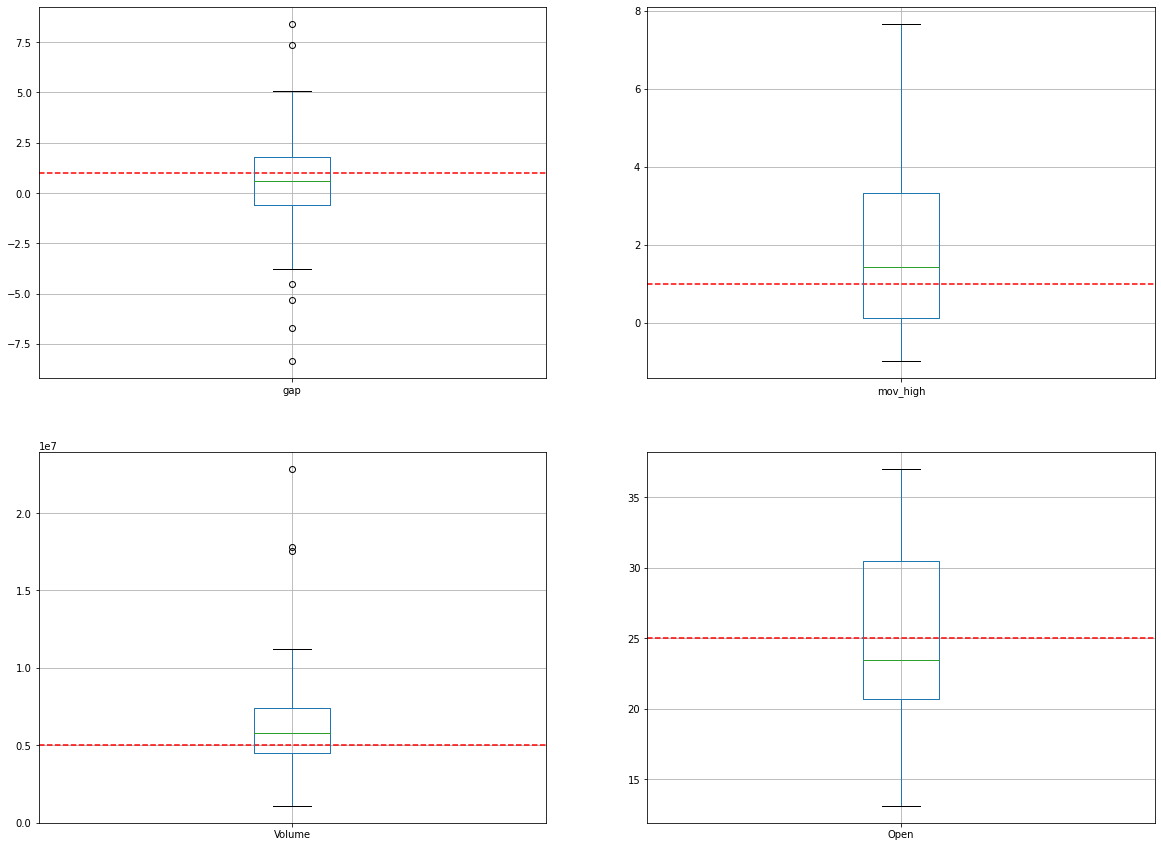

In [ ]:
fig = plt.figure(figsize=(20,15))


ax1 = fig.add_subplot(221)
ax1.axhline(1, c='r', ls='--')

ax2 = fig.add_subplot(222)
ax2.axhline(1, c='r', ls='--')
ax3 = fig.add_subplot(223)
ax3.axhline(5000000, c='r', ls='--')
ax4 = fig.add_subplot(224)
ax4.axhline(25, c='r', ls='--')

df_6meses.boxplot('gap',ax=ax1)
df_6meses.boxplot('mov_high', ax=ax2)
df_6meses.boxplot('Volume', ax=ax3)
df_6meses.boxplot('Open', ax=ax4)


In [ ]:
n = len(df_6meses)

In [ ]:

df_filtrada_6meses = df_6meses.copy()

# mov_high > 1% (esto puede ser un rango tb)
#df_filtrada = df_filtrada.loc[(df_filtrada['mov_high'] < 5) & (df_filtrada['mov_high'] >= 0.62), :]
df_filtrada_6meses = df_filtrada_6meses.loc[df_filtrada_6meses['mov_high'] >= 1, :]
#print(len(df_filtrada_6meses) / n * 100)

# gap < 1%
df_filtrada_6meses= df_filtrada_6meses.loc[df['gap'] <= 1, :]
#print(len(df_filtrada_6meses) / n * 100)


df_filtrada_6meses = df_filtrada_6meses.loc[df_filtrada_6meses['Open'] >= Q1(df_filtrada_6meses['Open']), :]
#print(len(df_filtrada_6meses) / n * 100)

# Volumen > 500000
df_filtrada_6meses = df_filtrada_6meses.loc[df_filtrada_6meses['Volume'] >= Q1(df_filtrada_6meses['Open']), :]

n_filtrado = len(df_filtrada_6meses)
p_sample = np.round(n_filtrado / n * 100,2)

summary['estrategias']['estrategia_2']['per_sample'] = p_sample
summary['estrategias']['estrategia_2']['sample'] = n_filtrado

print("Cantidad de puntos utilizados", n_filtrado)
print("Porcentaje de datos utilizados", per_sample)

Cantidad de puntos utilizados 18
Porcentaje de datos utilizados 15.32


In [ ]:
TP_6meses = np.round(df_filtrada_6meses['mov_high'].mean(),2)
SL_6meses = np.round(df_filtrada_6meses['mov_low'].mean(),2)
TR_6meses = np.round(df_filtrada_6meses['mov_high'].std(),2)

summary['estrategias']['estrategia_2']['indicadores'] = [TR_6meses, TP_6meses, SL_6meses]
print(TR_6meses, TP_6meses, SL_6meses)

1.77 2.63 -2.59


In [ ]:
summary

{'accion': 'AA',
 'estrategias': {'estrategia_0': {'indicadores': [1.99, 3.38, -2.27],
   'per_sample': 5.62,
   'sample': 68},
  'estrategia_1': {'indicadores': [1.02, 1.99, -2.11],
   'per_sample': 23.86,
   'sample': 289},
  'estrategia_2': {'indicadores': [1.77, 2.63, -2.59],
   'per_sample': 25.0,
   'sample': 18}}}

## Conclusiones

* Los indicadores utilizados previamente no parecen representar al conjunto de datos (falta extender el analisis al resto de las acciones)

* Tambien pueden contener datos extremos que distorsionen la utilidad del indicador (datos no confiables)

* Los variables de resultados y Efectividad deben aplicarse cuando se evaluen los indicadores, no cuando se esten calculando los mismos

### Filtros

* Volumen y Precios no parecen correlacionar con %mov, y gap, con lo cual se relajaron para aumentar la representitividad del conjunto de datos

* Se puso un cota superior a %mov_high para previnir outliers, y ensuciar el calculo


Se proponen 2 abordajes complementarios al original

* uno distriubuido/extensivo a todos los datos, pero aumentendo la cantidad de datos utilizados y con datos confiables/limpios

* uno "Local" utilizando datos proximos a los de evaluacion, para determinar si hay un efecto de "proximididad", tambien los mas representativos posible.


El exito o fracaso de los abordajes se deberan determinar evaluando resultado y efectividad en conjunto sobre un conjunto de datos, "nuevos" apicando la tecnica de backtest 

## Pasos a seguir

* Implementar el Backtest

* Extender elanalisis y calculo de TP, SL y TR al resto de las acciones de acuerdo a los 3 abordajes propuestos  para poder comparar Resultado y Efectividad de los mismo.
